# Pixel Wise Classification of liver slices

To classify every pixel in a given image, the classification network has to be "rolled" over the image with a stride 1

In [8]:
from google.colab import drive

drive.mount('/content/drive')

!ls "/content/drive/My Drive/PyCon/PyTorch/data/data"

Mounted at /content/drive
2DLiverSlices_128.h5.zip  pertained_models  test_images


In [2]:
# import the libraries
import skimage.io as sio # for reading an image
import numpy as np

import matplotlib.pyplot as plt # for plotting
%matplotlib inline
plt.set_cmap('gray')

# importing torch libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

# generic libraries
import os
import time

### Read the image

image `liver_slice_4x.png` is padded by `[32, 32]`. Therefore, initial image size is `192x192` after `128x128` is padded with `32x32` on all sides.

Image shape: (192, 192)


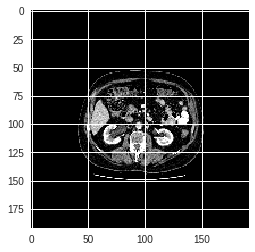

In [3]:
x = sio.imread('/content/drive/My Drive/PyCon/PyTorch/data/data/test_images/liver_slice_4x.png')
x = x / 255 # normalize image to 0 to 1
plt.imshow(x)
print('Image shape: ' + str(x.shape))

## Define the classification network

``` Conv1 -> Conv2 -> MaxPool2D -> Conv3 -> Conv4 -> MaxPool2D -> FC1 -> FC2 -> LogSoftMax```

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3), nn.BatchNorm2d(32))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3), nn.BatchNorm2d(64))
        
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3), nn.BatchNorm2d(128))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3), nn.BatchNorm2d(128))
        
        self.fc1 = nn.Sequential(nn.Linear(3200, 500), nn.BatchNorm1d(500))
        self.fc2 = nn.Sequential(nn.Linear(500, 2), nn.BatchNorm1d(2))
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1) # Rasterizes tensor by preserving 0th dimension
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

## Load the checkpoint for the saved model

In [10]:
model = Net().float()
checkpoint = torch.load(r'/content/drive/My Drive/PyCon/PyTorch/data/data/pertrained_models/pwcNetwork_cpu.tar')
model.load_state_dict(checkpoint['state_dict'])
model = model.float()

FileNotFoundError: ignored

In [14]:
!ls '/content/drive/My Drive/PyCon/PyTorch/data/data/pertrained_models'

ls: cannot access '/content/drive/My Drive/PyCon/PyTorch/data/data/pertrained_models': No such file or directory


In [0]:
PATCH_SIZE = [32, 32]

## Rolling the network on the image

Roll the network / raster-scan the image from top-left to bottom-right.

To counter the reduction in image-size because of not processing the edge pixels, the image is padded with zeros.

Hence, the starting and ending point of this rolling for every row is `patch_size` and `image_shape - patch_size`

In [0]:
model.eval()

out_image = []

start_y, end_y = PATCH_SIZE[0], x.shape[0] - PATCH_SIZE[0]
start_x, end_x = PATCH_SIZE[1], x.shape[1] - PATCH_SIZE[1]

for i in range(start_y, end_y):
    
    start_time = time.time()
    
    for j in range(start_x, end_x):
        
        center = [i, j]
        
        # extract patch
        patch = x[center[0]-PATCH_SIZE[0]//2 : center[0]+PATCH_SIZE[0]//2,
                  center[1]-PATCH_SIZE[1]//2 : center[1]+PATCH_SIZE[1]//2]
        
        # pre-process patch for forward pass
        patch = patch.reshape(1, 1,PATCH_SIZE[0], PATCH_SIZE[1])
        patch = torch.from_numpy(patch)
        patch = Variable(patch, volatile=True)
        patch = patch.float()
        
        # predict with model
        out = model.forward(patch)
        
        # convert Variables into NumPy arrays
        out = out.data.numpy()
        out_image.append(out)
        
    print('Rows processed: ' + str(i+1 - PATCH_SIZE[0]) + ' Time taken: ' + str(time.time() - start_time))

## Post process the output image

In [0]:
out_image = np.array(out_image) # Convert list into array
out_image = np.exp(out_image) # Torch network gives out log softmax outputs. Nullify log by applying exp operation

Output tensor is `[N, 1, 2]` in shape where `N` is the number of patches processed during raster scanning a.k.a "rolling".

`np.argmax` on the `2`nd dimension will return binary values for every patch

Once all the patches are binarized, the tensor is reshaped into a `128x128` 2D array

In [0]:
final_output = np.argmax(out_image, axis=2).reshape(128, 128) # Take argmax along probability dimension

## Plot the image

In [0]:
# plot the predicted image
plt.imshow(final_output)

# plot the original image
plt.figure()
plt.imshow(x[PATCH_SIZE[0] : x.shape[0]-PATCH_SIZE[0],
             PATCH_SIZE[1] : x.shape[1]-PATCH_SIZE[1]]) # crop the original image by the padded amount